In [1]:
import os
import numpy as np
import pandas as pd
import ast
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

# Function to generate filenames based on time intervals
def generate_time_file_names(start_time_str, end_time_str, folder_path, prefix='optimal_file_data_'):
    start_time = datetime.strptime(start_time_str, '%H_%M_%S')
    end_time = datetime.strptime(end_time_str, '%H_%M_%S')
    current_time = start_time
    while current_time <= end_time:
        time_str = current_time.strftime('%H_%M_%S')
        file_name = f"{prefix}{time_str}.csv"
        yield os.path.join(folder_path, file_name)
        current_time += timedelta(seconds=20)

# Function to load and process data
def load_data(file_names):
    data_list = []
    for file_name in file_names:
        if os.path.exists(file_name):
            df = pd.read_csv(file_name, usecols=['feed_sat', 'Latitude', 'Longitude', 'Altitude', 'optimal_gateway_matrix'])
            df.dropna(inplace=True)
            data_list.append(df)
    return pd.concat(data_list, ignore_index=True) if data_list else None

# Time range settings
start_time_train = '16_00_00'
end_time_train = '19_00_00'
start_time_test = '19_00_00'
end_time_test = '20_30_00'
folder_path = r"C:\Users\aruna\Desktop\MS Thesis\Real Data\Files with position"

train_files = list(generate_time_file_names(start_time_train, end_time_train, folder_path))
test_files = list(generate_time_file_names(start_time_test, end_time_test, folder_path))

train_data = load_data(train_files)
test_data = load_data(test_files)

# Feature and target extraction
X_train = train_data[['feed_sat', 'Latitude', 'Longitude', 'Altitude']].values
X_test = test_data[['feed_sat', 'Latitude', 'Longitude', 'Altitude']].values

def parse_gateway_matrix(matrix_str):
    try:
        return np.array(ast.literal_eval(matrix_str))
    except:
        return None

train_data['optimal_gateway_matrix'] = train_data['optimal_gateway_matrix'].apply(parse_gateway_matrix)
test_data['optimal_gateway_matrix'] = test_data['optimal_gateway_matrix'].apply(parse_gateway_matrix)
train_data.dropna(subset=['optimal_gateway_matrix'], inplace=True)
test_data.dropna(subset=['optimal_gateway_matrix'], inplace=True)

y_train = np.vstack(train_data['optimal_gateway_matrix'].values)
y_test = np.vstack(test_data['optimal_gateway_matrix'].values)
num_gateways = y_train.shape[1]

# Normalization
scaler = MinMaxScaler()
X_train[:, :] = scaler.fit_transform(X_train)
X_test[:, :] = scaler.transform(X_test)

def lr_schedule(epoch, lr):
    if epoch < 5:  # Reduce LR sooner
        return lr
    elif epoch < 10:
        return lr * 0.5
    else:
        return lr * 0.1


lr_scheduler = LearningRateScheduler(lr_schedule)

# Model architecture
model = Sequential([
    Dense(256, kernel_regularizer='l2'),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.5),  # Increased from 0.4

    Dense(128, kernel_regularizer='l2'),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.4),  # Increased from 0.3

    Dense(64, kernel_regularizer='l2'),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.4),  # Increased from 0.3

    Dense(num_gateways, activation='softmax')
])


# Compile model
from tensorflow.keras.optimizers import RMSprop
optimizer = RMSprop(learning_rate=0.001, rho=0.9)

model.compile(optimizer=optimizer, loss=CategoricalCrossentropy(label_smoothing=0.1), metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_reducer = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-7)

# Training
history = model.fit(X_train, y_train,
                    validation_split=0.2,  
                    epochs=75,  
                    batch_size=256,  
                    verbose=1,
                    callbacks=[early_stopping, lr_reducer, lr_scheduler])

# Evaluation
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"\nTraining Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Compute Top-K Accuracy
def compute_top_k_accuracy(model, X_test, y_test, k_values=[1, 3, 5]):
    predictions = model.predict(X_test)
    top_k_indices = {k: np.argsort(predictions, axis=1)[:, -k:] for k in k_values}
    y_true = np.argmax(y_test, axis=1)
    top_k_accuracies = {k: np.mean(np.any(top_k_indices[k] == y_true[:, None], axis=1)) * 100 for k in k_values}
    return top_k_accuracies

top_k_accuracies = compute_top_k_accuracy(model, X_test, y_test, k_values=[1, 3, 5])
print("\nTop-K Accuracy Results:")
for k, acc in top_k_accuracies.items():
    print(f"Top-{k} Accuracy: {acc:.2f}%")

# Save model
model.save('optimized_NN_model_1.h5')
print("\nModel training and evaluation complete!")


c:\Users\aruna\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Epoch 1/75
7725/7725 ━━━━━━━━━━━━━━━━━━━━ 57s 7ms/step - accuracy: 0.2752 - loss: 2.8816 - val_accuracy: 0.3372 - val_loss: 2.4015 - learning_rate: 0.0010
Epoch 2/75
7725/7725 ━━━━━━━━━━━━━━━━━━━━ 50s 6ms/step - accuracy: 0.3259 - loss: 2.5132 - val_accuracy: 0.3639 - val_loss: 2.3695 - learning_rate: 0.0010
Epoch 3/75
7725/7725 ━━━━━━━━━━━━━━━━━━━━ 54s 7ms/step - accuracy: 0.3274 - loss: 2.5063 - val_accuracy: 0.3367 - val_loss: 2.4132 - learning_rate: 0.0010
Epoch 4/75
7725/7725 ━━━━━━━━━━━━━━━━━━━━ 53s 7ms/step - accuracy: 0.3271 - loss: 2.5049 - val_accuracy: 0.3876 - val_loss: 2.3530 - learning_rate: 0.0010
Epoch 5/75
7725/7725 ━━━━━━━━━━━━━━━━━━━━ 54s 7ms/step - accuracy: 0.3274 - loss: 2.5046 - val_accuracy: 0.3577 - val_loss: 2.3473 - learning_rate: 0.0010
Epoch 6/75
7725/7725 ━━━━━━━━━━━━━━━━━━━━ 61s 8ms/step - accuracy: 0.3448 - loss: 2.4449 - val_accuracy: 0.3605 - val_loss: 2.2877 - learning_rate: 5.0000e-04
Epoch 7/75
7725/7725 ━━━━━━━━━━━━━━━━━━━━ 59s 8ms/step - accuracy:


Top-K Accuracy Results:
Top-1 Accuracy: 42.95%
Top-3 Accuracy: 75.46%
Top-5 Accuracy: 87.06%

Model training and evaluation complete!


In [3]:
import joblib
joblib.dump(scaler, "scaler_2.pkl")


['scaler_2.pkl']

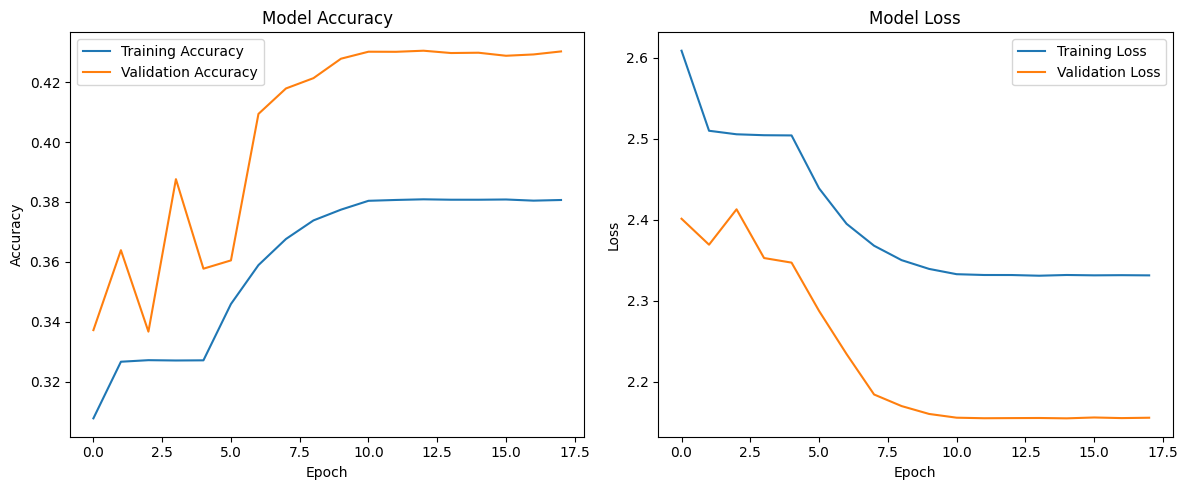

In [4]:
import matplotlib.pyplot as plt
# Visualize Training History (Accuracy & Loss)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()